<a id="tercero"></a>
## 3. Autoencoders (AEs) en MNIST
Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, denoising y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST. Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen


> a) Escriba una función que cargue los datos desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación utilizando los últimos $nval = 5000$ casos del conjunto del entrenamiento. El conjunto de entrenamiento consistirá en las primeras $60000 - nval$ imágenes.
```python
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
#Define here your validation set
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
```



In [2]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils, plot_model

(x_training, y_training), (x_test, y_test) = mnist.load_data()

print("Las dimensiones del dataframe de entrenamiento son:",x_training.shape)
print("Las dimensiones del dataframe de entrenamiento son:",y_training.shape)
print("Las dimensiones del dataframe de pruebas son:",x_test.shape)
print("Las dimensiones del dataframe de pruebas son:",y_test.shape)

Las dimensiones del dataframe de entrenamiento son: (60000, 28, 28)
Las dimensiones del dataframe de entrenamiento son: (60000,)
Las dimensiones del dataframe de pruebas son: (10000, 28, 28)
Las dimensiones del dataframe de pruebas son: (10000,)


En la celda anterior se carga el dataset a utilizar en la actividad, tal como se enunció en el encabezado.   
MNIST está compuesto por 70000 imágenes de un único canal con una dimensión de 28x28 pixeles. Estas imágenes, por defecto, estan divididas en 60000 y 10000 como conjuntos de entrenamiento y pruebas respectivamente. Por ello, a continuación se realiza una nueva partición en el conjunto de entrenamiento a fin de manejar un pequeño conjunto de validación.  

Así entonces se tienen:  

- 55000 datos de entrenamiento
- 5000 datos de validación 
- 10000 datos de pruebas


In [3]:
x_training = x_training.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train=x_training[:55000]
y_train=y_training[:55000]
x_val=x_training[55000:]
y_val=y_training[55000:]

print("Las dimensiones del dataframe de entrenamiento son:",x_train.shape)
print("Las dimensiones del dataframe de entrenamiento son:",y_train.shape)
print("Las dimensiones del dataframe de validación son:",x_val.shape)
print("Las dimensiones del dataframe de validación son:",y_val.shape)
print("Las dimensiones del dataframe de pruebas son:",x_test.shape)
print("Las dimensiones del dataframe de pruebas son:",y_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Las dimensiones del dataframe de entrenamiento son: (55000, 28, 28)
Las dimensiones del dataframe de entrenamiento son: (55000,)
Las dimensiones del dataframe de validación son: (5000, 28, 28)
Las dimensiones del dataframe de validación son: (5000,)
Las dimensiones del dataframe de pruebas son: (10000, 28, 28)
Las dimensiones del dataframe de pruebas son: (10000,)


Se procesan los datos originales llevando a cabo la tarea de normalización dejándolos en el intervalo 0-1 (valor/máximo_valor) a fin de evitar futuros sesgos del algoritmo/modelo a utilizar. Igualmente, se transformaron los vectores target (y_train, y_val, y_test), con valores entre 0 y 10, a matrices de clase binaria. 

### 3.1 Reducción de dimensionalidad
Para esta primera sección se trabajará con un autoencoder tradicional (*feed forward*) en donde las capas de este son densas. Para esto se re estructuraran los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

```python
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
```

Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \leftarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento
> a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación **ReLU** para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?
```python
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
##
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoder_768x32.h5')
#save other stuffs
```



En la siguiente celda se realiza un preprocesamiento extra a los datos presentados. Esto es, transformar la imagen de 28x28 a un vector de 784 componentes. Es decir, se transforma el objeto de dos dimensiones en un único vector extendido.

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from IPython.display import Image, display, SVG

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print("Las dimensiones del dataframe de entrenamiento son:",x_train.shape)
print("Las dimensiones del dataframe de entrenamiento son:",y_train.shape)
print("Las dimensiones del dataframe de validación son:",x_val.shape)
print("Las dimensiones del dataframe de validación son:",y_val.shape)
print("Las dimensiones del dataframe de pruebas son:",x_test.shape)
print("Las dimensiones del dataframe de pruebas son:",y_test.shape)

Las dimensiones del dataframe de entrenamiento son: (55000, 784)
Las dimensiones del dataframe de entrenamiento son: (55000,)
Las dimensiones del dataframe de validación son: (5000, 784)
Las dimensiones del dataframe de validación son: (5000,)
Las dimensiones del dataframe de pruebas son: (10000, 784)
Las dimensiones del dataframe de pruebas son: (10000,)


Habiendo definido lo anterior, se construye un Autoencoder básico constituído por una capa escondida (encoder) y su respectivo decoder. Las variantes de este modelo se pueden apreciar en la siguiente celda visualizando los respectivos esquemas.  
Así mismo, se presenta a continuación la codificación utilizada la cual varía desde las 2 hasta las 64 componentes, es decir, el vector de 784 componentes es comprimido en 2, 8, 32 y 64 dimensiones asimilando el siguiente comportmiento:

\begin{align}
\mathbb{R} ^ I \rightarrow \mathbb{R}^{dim} \rightarrow \mathbb{R}^I 
\end{align}


donde I = $input_{shape}$= 784 y dim $\in$ {2, 8, 32 , 64}

La función de activación seleccionada para la capa escondida (encoder) es la sigmoidal.  

Cabe destacar justamente que el objetivo de la utilización de un autoencoder, tal como se expone en este apartado, es la reducción de dimensionalidad hacia un vector de menos componentes que permita representar fielmente el input original a través de la decodificación del modelo.

Entrenando modelo para  2 dimensiones
Autoencoder


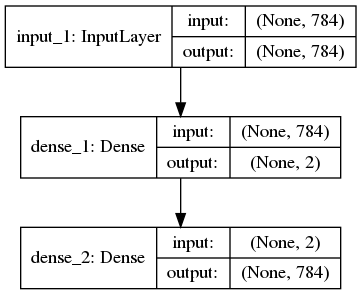

Encoder


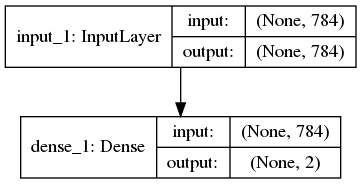

Decoder


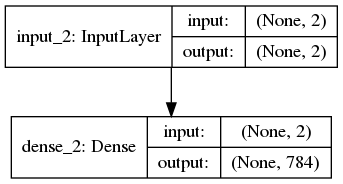

Entrenando modelo para  8 dimensiones
Autoencoder


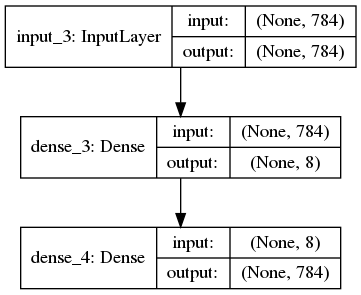

Encoder


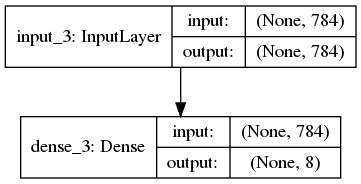

Decoder


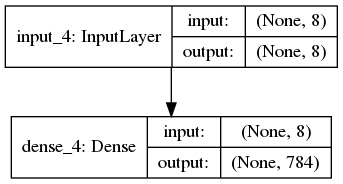

Entrenando modelo para  32 dimensiones
Autoencoder


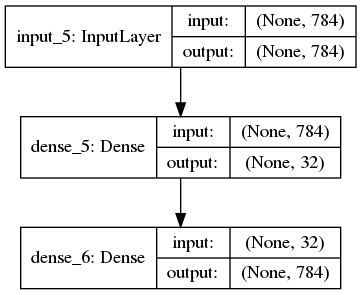

Encoder


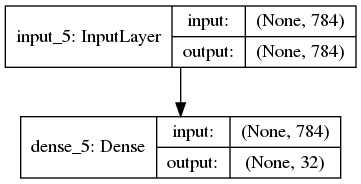

Decoder


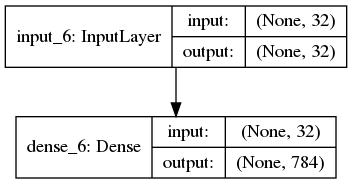

Entrenando modelo para  64 dimensiones
Autoencoder


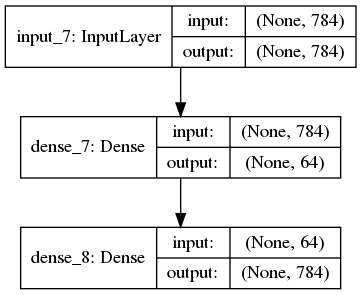

Encoder


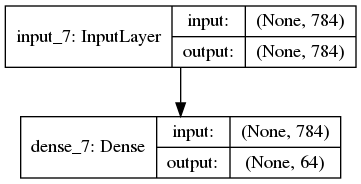

Decoder


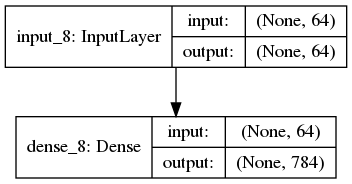

In [4]:
dimns=[2,8,32,64]
hist1=[]
for dim in dimns:
    print ("Entrenando modelo para ", dim, "dimensiones")
    input_img = Input(shape=(784,))
    encoded = Dense(dim, activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    print ("Autoencoder")
    plot_model(autoencoder, to_file='model_auto1.png', show_shapes=True)
    display(Image(filename='model_auto1.png'))
    print ("Encoder")
    plot_model(encoder, to_file='model_enc1.png', show_shapes=True)
    display(Image(filename='model_enc1.png'))
    print ("Decoder")
    plot_model(decoder, to_file='model_dec1.png', show_shapes=True)
    display(Image(filename='model_dec1.png'))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,verbose=0,shuffle=True,validation_data=(x_val, x_val))
    autoencoder.save('basic_autoencoder_sig_768x'+str(dim)+'.h5')
    hist1.append(hist)




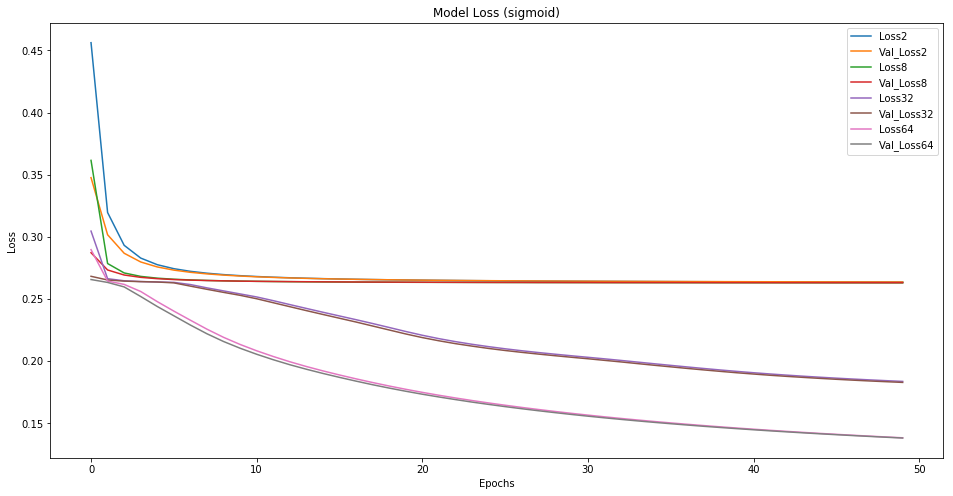

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline

i=0
plt.figure(figsize=(16, 8))
for hist in hist1: 
    plt.plot(hist.history['loss'],label="Loss"+str(dimns[i]))
    plt.plot(hist.history['val_loss'],label="Val_Loss"+str(dimns[i]))   
    i+=1
    
plt.title("Model Loss (sigmoid)") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()


En las celdas anteriores se entrena el autoencoder mediante optimizador **SGD con tasa de aprendizaje 1** y función de pérdida **binary cross-entropy**, esta función es requerida ya que la salida de la red (input reconstruido) se modela de manera tal que cada componente es independiente del resto puesto que se reconstruye cada componente de manera separada.  

El gráfico presentado presenta la pérdida (**loss**) en función del número de epochs, mostrándo que es bastante bajo alcanzando valores menores a **0.27** dentro de los primeros **10 epochs**. Se puede observar que la loss (error de reconstrucción del input) disminuye constantemente en cada epoch.


### ReLU

A continuación se redefine el modelo de autoencoder básico, modificando la función de activación del encoder (capa oculta) hacia una **ReLU** para así descubrir qué ventajas o empeoramientos se observan respecto al desempeño del modelo. 

In [ ]:
hist1_relu=[]
for dim in dimns:
    print ("Entrenando modelo para ", dim, "dimensiones")
    input_img = Input(shape=(784,))
    encoded = Dense(dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,verbose=0,shuffle=True,validation_data=(x_val, x_val))
    autoencoder.save('basic_autoencoder_relu_768x'+str(dim)+'.h5')
    hist1_relu.append(hist)


Entrenando modelo para  2 dimensiones
Entrenando modelo para  8 dimensiones


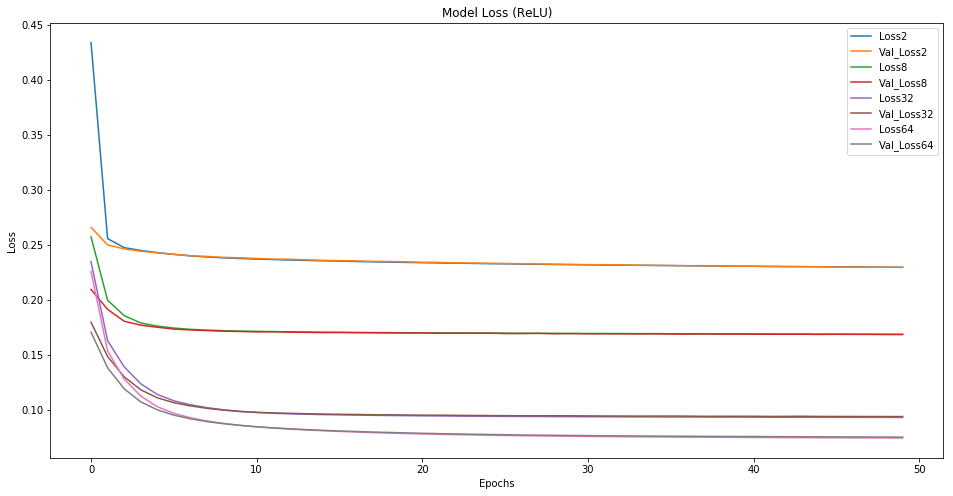

In [17]:
import matplotlib.pyplot as plt 
%matplotlib inline

i=0
plt.figure(figsize=(16, 8))
for hist in hist1_relu: 
    plt.plot(hist.history['loss'],label="Loss"+str(dimns[i]))
    plt.plot(hist.history['val_loss'],label="Val_Loss"+str(dimns[i]))   
    i+=1
    
plt.title("Model Loss (ReLU)") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()


Anteriormente se entrena el autoencoder de la misma forma que con el modelo sigmoidal presentando su desempeño en el gráfico recién expuesto. Se observa que **esta variante obtiene mejor desempeño que la configuración previa (sigmoid)** puesto que el error de reconstrucción es mucho más bajo alcanzado valores aproximados a **0.10 desde el epoch número 10**. Además, cabe destacar que la velocidad de entrenamiento es mucho mayor puesto la loss disminuye con gran intensidad y en una cantidad reducida de epochs.

Ahora bien, independientemente de la función de activación a utilizar en el autoencoder definido, cabe mencionar que **no se estuvo frente a situaciones de sobreajuste/overfitting**. Es más, dentro de los primeros 3-4 epochs se observó que la loss del conjunto de validacón fue (en algunos casos) mucho menor que la loss acusada por el conjunto de entrenamiento por lo que se podía afirmar que el modelo cumplía con el requisito de generalidad.  
Esta situación puede explicarse debido a que el problema corresponde a un problema no supervisado cuyo objetivo es reconstruir el input original comprimido en un espacio de menor dimensión del que se extraen características para la distinción de los datos.

> b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.
```python
from keras.models import load_model
autoencoder = load_model('basic_autoencoder_768x32.h5')
#load other stuff ...
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
import matplotlib
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
```



A continuación se presentan las reconstrucciones obtenidas por el modelo entrenado bajo función de activación Sigmoidal y ReLU, todo esto en base a las diferentes dimensiones de reducción tratadas. 

### Sigmoid

Reconstrucción obtenida con 2 dimensiones
10000/10000 [==============================] - 1s 61us/step
Error de reconstruccion encoder: 0.2633482473373413


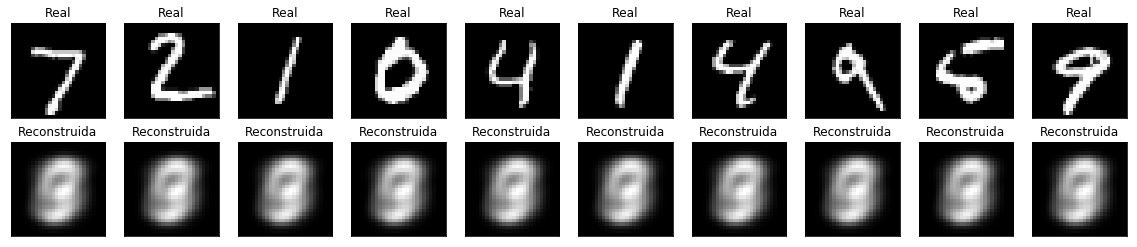

Reconstrucción obtenida con 8 dimensiones
10000/10000 [==============================] - 1s 63us/step
Error de reconstruccion encoder: 0.2627177175998688


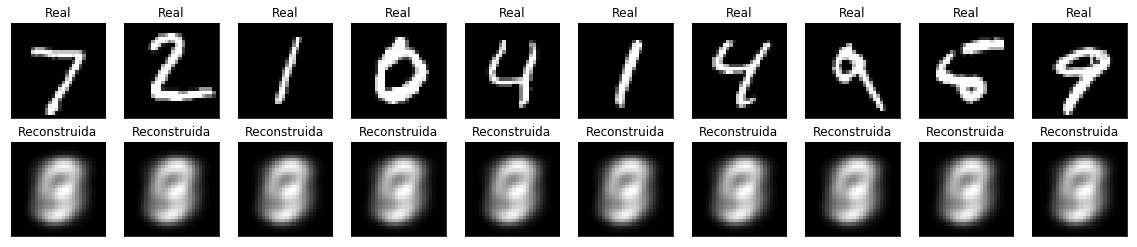

Reconstrucción obtenida con 32 dimensiones
10000/10000 [==============================] - 1s 65us/step
Error de reconstruccion encoder: 0.18158046033382416


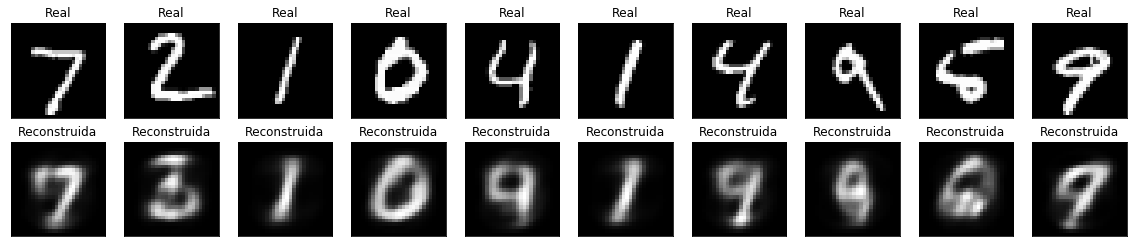

Reconstrucción obtenida con 64 dimensiones
10000/10000 [==============================] - 1s 67us/step
Error de reconstruccion encoder: 0.13861064875125886


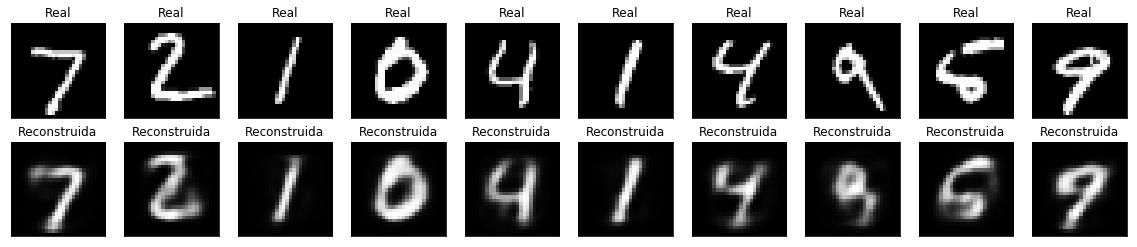

In [18]:
from keras.models import load_model

for dim in dimns:
    print ("Reconstrucción obtenida con", str(dim), "dimensiones")
    autoencoder = load_model('./basic_autoencoder_sig_768x'+str(dim)+'.h5')
    #Reconstruir desde autoencoder (encoder --> decoder)
    score = autoencoder.evaluate(x_test,x_test)
    print ("Error de reconstruccion encoder:", score) 
    
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
    decoded_shape = Input(shape=(dim,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)  
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):    
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Real")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruida")    
    plt.show()

### ReLU

Reconstrucción obtenida con 2 dimensiones (ReLU) 
10000/10000 [==============================] - 1s 75us/step
Error de reconstruccion encoder: 0.22855340344905853


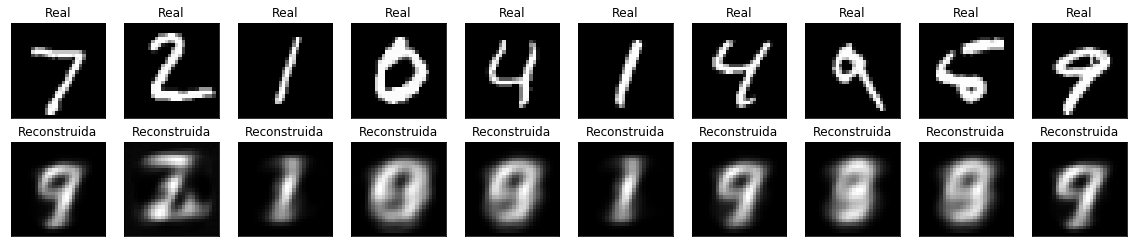

Reconstrucción obtenida con 8 dimensiones (ReLU) 
10000/10000 [==============================] - 1s 74us/step
Error de reconstruccion encoder: 0.16724908947944642


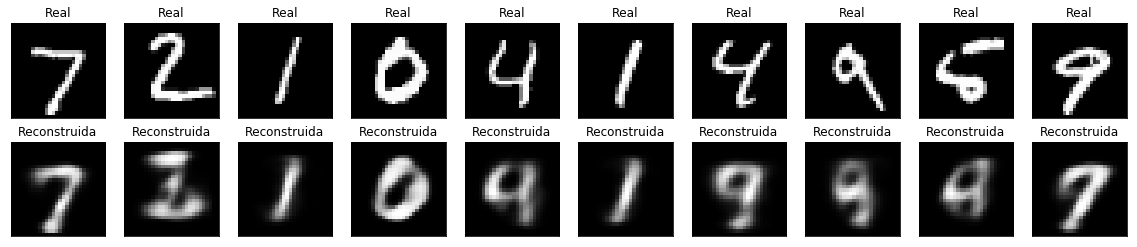

Reconstrucción obtenida con 32 dimensiones (ReLU) 
10000/10000 [==============================] - 1s 77us/step
Error de reconstruccion encoder: 0.09219028354883194


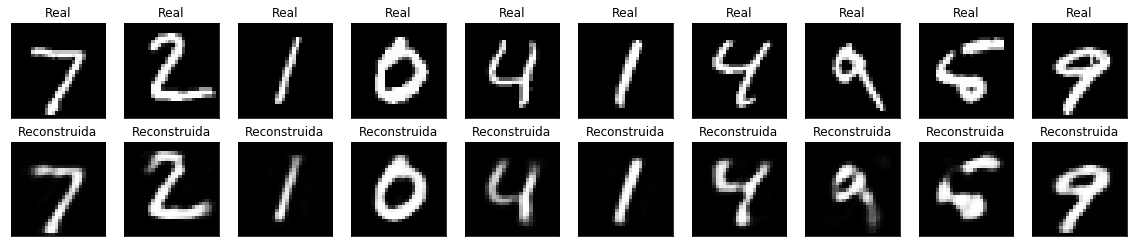

Reconstrucción obtenida con 64 dimensiones (ReLU) 
10000/10000 [==============================] - 1s 77us/step
Error de reconstruccion encoder: 0.07401222167015076


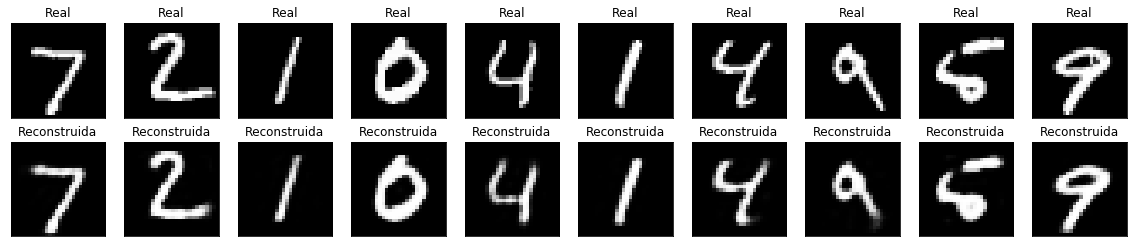

In [20]:
for dim in dimns:
    print ("Reconstrucción obtenida con", str(dim), "dimensiones (ReLU) ")
    autoencoder = load_model('./basic_autoencoder_relu_768x'+str(dim)+'.h5')
    #Reconstruir desde autoencoder (encoder --> decoder)
    score = autoencoder.evaluate(x_test,x_test)
    print ("Error de reconstruccion encoder:", score) 
    
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
    decoded_shape = Input(shape=(dim,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)  
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):    
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Real")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruida")    
    plt.show()

**Un comportamiento compartido entre los modelos Sigmoid y ReLU** corresponde a que la reconstrucción generada por cada uno con distintas dimensiones en el encoder (2, 8, 32, 64) demuestra estar bastante asociado al error de reconstrucción del modelo puesto que con menos dimensiones en la representación codificada, la reconstrucción es peor siendo bastante borrosa (2 y 8 dimensiones)y perdiendo, la mayoria de las veces, la forma del dígito reconstruído puesto que resultó ser incorrecto comparado a la imagen verdadera.   
Ahora bien, cuando el número de dimensiones en el encoder aumenta consisderablemente, (32 y 64) se tiene una reconstrucción mucho más clara siendo con 64 dimensiones prácticamente idéntica a la imagen verdadera.   

Este desempeño se corresponde con lo observado en los gráficos previos en donde los modelos de mayor dimensionalidad resultaron ser aquellos que acusaron niveles de loss más bajos. 




**Un comportamiento diferido entre los modelos Sigmoid y ReLU** corresponde a que es clara la superioridad del modelo ReLU sobre Sigmoid en base a que la reconstrucción de dimensionalidad $d$ en un modelo ReLU es mucho más clara que esn un modelo para la misma dimensionalidad Sigmoid; Lo mismo ocurre con su error de reconstrucción. Por ello, es posible afirmar que ReLU corresponde a la función de activación más acertada para este tipo de problema.


> c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error de pruebas obtenido construyendo este clasificador sobre la data reducida a través del autocnder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios.
```python
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=d)
#PCA
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
#AUTOENCODER
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
#CLASIFICATION
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
print 'Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test)
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print 'Classification Accuracy %.2f' % clf.score(encoded_test,y_test)
```



En esta celda se verifica la calidad de la representación obtenida (codificación) bajo diferentes dimensionalidades en base al modelo ReLU puesto que éste es el que acusó mejores desempeños dada la evidencia presentada anteriormente.  
Así entonces se mide el **accuracy** obtenido mediante el clasificador **k-NN** para predecir la etiqueta correcta del dígito escrito, basándose en los K vecinos más cercanos en distancia euclideana entrenado sobre training set y evaluado sobre el testing set.  


In [19]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import time

for dim in dimns:
    print ("\nComparación ajuste obtenido con", str(dim), "dimensiones")
    autoencoder = load_model('./basic_autoencoder_relu_768x'+str(dim)+'.h5')
    #Evaluate performance 
    score = autoencoder.evaluate(x_test,x_test)    
    print ("Error de reconstruccion encoder:", score)   
    
    #Reconstruir los encoder desde el autoencoder
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    inicio = time.time()
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))    
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    #mean accuracy on the given test data
    print ("Encoder Accuracy en datos",dim,"-dimensionales",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")

    inicio = time.time()
    pca = PCA(n_components=dim)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    #mean accuracy on the given test data
    print ("PCA Accuracy en datos",dim,"-dimensionales",clf.score(pca_test,y_test) ,"con", (time.time() - inicio),"segundos") 


Comparación ajuste obtenido con 2 dimensiones
10000/10000 [==============================] - 1s 83us/step
Error de reconstruccion encoder: 0.22973107354640962
Encoder Accuracy en datos 2 -dimensionales 0.384 con 2.150782585144043 segundos
PCA Accuracy en datos 2 -dimensionales 0.4378 con 3.934356927871704 segundos

Comparación ajuste obtenido con 8 dimensiones
10000/10000 [==============================] - 1s 84us/step
Error de reconstruccion encoder: 0.1660864952325821
Encoder Accuracy en datos 8 -dimensionales 0.8999 con 3.169844150543213 segundos
PCA Accuracy en datos 8 -dimensionales 0.9025 con 5.471010446548462 segundos

Comparación ajuste obtenido con 32 dimensiones
10000/10000 [==============================] - 1s 85us/step
Error de reconstruccion encoder: 0.09215293523073197
Encoder Accuracy en datos 32 -dimensionales 0.9668 con 39.98647141456604 segundos
PCA Accuracy en datos 32 -dimensionales 0.9744 con 35.70294213294983 segundos

Comparación ajuste obtenido con 64 dimension

Implementando un clasificador k-nearest neighbor, dada una imagen, el clasificador busca las k = 10 imágenes de entrenamiento más similares y predice como clase la etiqueta más popular entre estas imágenes cercanas. 

El error de pruebas obtenido construyendo este clasificador sobre la data reducida a través del autoencoder comparando con la representación obtenida mediante PCA en base a las dimensiones tratatas previamente ($d \in$ {2, 8, 32, 64}) se puede afirmar que:  

* El error de reconstrucción disminuye en la medida que aumenta la dimensionalidad de la reducción. Esto es, en la medida que se comprime menos la información observada como entrada. 
* La representación obtenida en base a PCA supera marginalmente, para todas las dimensionalidades testeadas, el accuracy obtenido.
* A pesar de que el accuracy es mayor para toda dimensión, el tiempo de cómputo no siempre es menor en este tipo de representación. Así, para las dimensiones más bajas (2 y 8), el tiempo en el que se incurrió por parte de PCA fue mayor al utilizado por k-NN mientras que para las dimensionalidades mayores (32 y 64) el tiempo de PCA fue menor versus k-NN.
* El nivel de accuracy no se corresponde con error de reconstrucción observado. Esto es, basándose sólo en el accuracy, el mejor modelo lo es aquel de 32 dimensiones mientras que, en base a error de reconstrucción, el mejor modelo resulta ser aquel de 64 dimensiones. Sin embargo, accuracy y error de reconstrucción sí se corresponden en las dimensionalidades más bajas. 

Cabe destacar que, a pesar de que ciertas representaciones acusaron mejor accuracy y/o errores de reconstrucción, los niveles de precisión fueron bastante considerando el dominio del problema; dominio en el que 2 o 3 puntos porcentuales e error no resulta ser grave.  
Igualmente, los resultados aquí enunciados muestran que la técnica de reducción de dimensionalidad PCA logra comprimir la información de los datos en un subespacio que beneficia a la tarea de etiquetar el dígito presente en la imagen en cuestión versus el autoencoder. Esto se puede deber a que el modelo de autoencoder entrenado es bastante simple en comparación a PCA.

> d) Modifique el autoencoder básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades (L = 2, 3, 4). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.
```python
target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('my_autoencoder_768x1000x500x250x2.h5')
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=target_dim)
pca.fit(x_train)
```




Dado que el modelo de autoencoder simple no superó el desempeño logrado por PCA, se trabaja a contiunación con un modelo profundo o **deep autoencoder** que comprime la información pasando por una cantidad mayor de capas ocultas.   
El número de capas a utilizar varía desde las 2 hasta las 4 capas ocultas con dimensionalidad 1000, 600 y 300. Es decir: 

#### 2 capas ocultas

- $\mathbb{R}^{784} \rightarrow \mathbb{R}^{1000}  \rightarrow \mathbb{R}^{dim}  \rightarrow \mathbb{R}^{1000} \rightarrow \mathbb{R}^{784} $


#### 3 capas ocultas

- $\mathbb{R}^{784} \rightarrow \mathbb{R}^{1000} \rightarrow \mathbb{R}^{600} \rightarrow \mathbb{R}^{dim} \rightarrow \mathbb{R}^{600} \rightarrow \mathbb{R}^{1000} \rightarrow \mathbb{R}^{784} $


#### 4 capas ocultas

- $\mathbb{R}^{784} \rightarrow \mathbb{R}^{1000} \rightarrow \mathbb{R}^{600} \rightarrow \mathbb{R}^{300} \rightarrow \mathbb{R}^{dim} \rightarrow \mathbb{R}^{300} \rightarrow \mathbb{R}^{600} \rightarrow \mathbb{R}^{1000} \rightarrow \mathbb{R}^{784} $




In [31]:
## entrenar red 2 capas
hist2=[]
for dim in dimns:
    print ("Entrenando modelo para ", dim, "dimensiones")
    input_img = Input(shape=(784,))
    encodeda = Dense(1000, activation='relu')(input_img)
    encodedb = Dense(dim, activation='relu')(encodeda)
    decodedb = Dense(1000, activation='relu')(encodedb)
    decodeda = Dense(784, activation='sigmoid')(decodedb)
    autoencoder = Model(inputs=input_img, outputs=decodeda)
    encoder = Model(inputs=input_img, outputs=encodedb)
    
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,verbose=0,shuffle=True,validation_data=(x_val, x_val))
    autoencoder.save('basic_autoencoder_2capasR_768x1000x'+str(dim)+'.h5')
    hist2.append(hist)


Entrenando modelo para  2 dimensiones
Entrenando modelo para  8 dimensiones
Entrenando modelo para  32 dimensiones
Entrenando modelo para  64 dimensiones


In [ ]:
#entrenar red 3 capas
hist3=[]
for dim in dimns:
    print ("Entrenando modelo para ", dim, "dimensiones")
    input_img = Input(shape=(784,))
    encodeda = Dense(1000, activation='relu')(input_img)
    encodedb = Dense(600, activation='relu')(encodeda)
    encodedc = Dense(dim, activation='relu')(encodedb)
    decodedc = Dense(600, activation='relu')(encodedc)
    decodedb = Dense(1000, activation='relu')(decodedc)
    decodeda = Dense(784, activation='sigmoid')(decodedb)
    autoencoder = Model(inputs=input_img, outputs=decodeda)
    #encoder = Model(inputs=input_img, outputs=encodedc)
    
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,verbose=0,shuffle=True,validation_data=(x_val, x_val))
    autoencoder.save('basic_autoencoder_3capasR_768x1000x600x'+str(dim)+'.h5')
    hist3.append(hist)


Entrenando modelo para  2 dimensiones


In [53]:
#entrenar red 4 capas
hist4=[]
for dim in dimns:
    print ("Entrenando modelo para ", dim, "dimensiones")
    input_img = Input(shape=(784,))
    encodeda = Dense(1000, activation='relu')(input_img)
    encodedb = Dense(600, activation='relu')(encodeda)
    encodedc = Dense(300, activation='relu')(encodedb)
    encodedd = Dense(dim, activation='relu')(encodedc)
    decodedd = Dense(300, activation='relu')(encodedd)
    decodedc = Dense(600, activation='relu')(decodedd)
    decodedb = Dense(1000, activation='relu')(decodedc)
    decodeda = Dense(784, activation='sigmoid')(decodedb)
    autoencoder = Model(inputs=input_img, outputs=decodeda)
    
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,verbose=0,shuffle=True,validation_data=(x_val, x_val))
    autoencoder.save('basic_autoencoder_4capasR_768x1000x600x300x'+str(dim)+'.h5')
    hist4.append(hist)


Entrenando modelo para  2 dimensiones
Entrenando modelo para  8 dimensiones
Entrenando modelo para  32 dimensiones
Entrenando modelo para  64 dimensiones


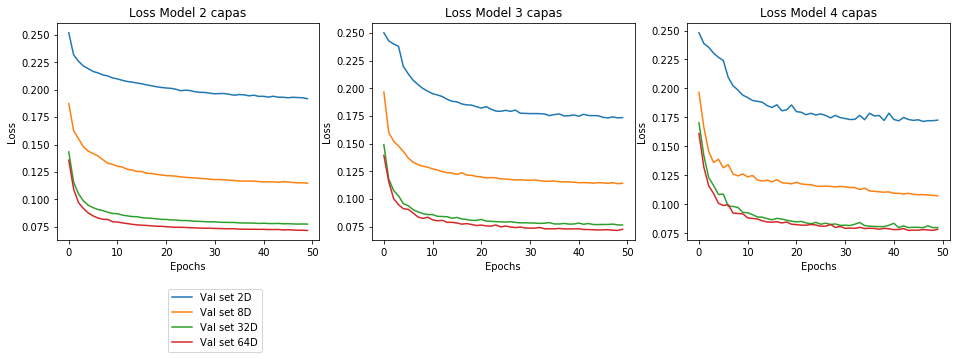

In [62]:
todo=[hist2,hist3,hist4]
f, axarr = plt.subplots(1,3, figsize=(16,4))
j=0
for history in todo: #para cada profundiad
    i=0
    for hist in history: #s,dimns): #para cada dimension
        axarr[j].plot( hist.history['val_loss'],label = "Val set "+str(dimns[i])+"D")
        axarr[j].set_title('Loss Model '+str(j+2)+ ' capas')
        axarr[j].set_xlabel('Epochs')
        axarr[j].set_ylabel('Loss')
        i+=1
    j+=1

axarr[0].legend(loc="upper right", fancybox= True,bbox_to_anchor=(.8,-.2))
plt.show()

Los gráficos presentados resumen el entrenamiento durante 50 epochs; éstos indican Loss respecto a Epochs y sólo enuncian la pérdida medida sobre el conjunto de validación puesto que es sabido que las decisiones respecto al modelo se toman sobre dicho conjunto.   

En la medida que aumenta la profundidad del modelo, para dimensionalidad 2, es claro que se obtienen mejoras en cuanto al desempeño alcanzado puesto que con una única capa oculta la loss en el epoch 50 es de **0.2 app** y para 4 capas ocultas este valor llega a **0.175 app**. Sin embargo, para las dimensiones mayores no se aprecian mejoras sino que sólo se mantienen en un rango de loss igual al de una única capa oculta.  
 

**Nota**
Se puede apreciar, al menos para dimensiones 32 y 64, que a mayor profundidad el entrenamiento inicia con niveles de loss más altos que en modelos con menor número de capas. Esto probablemente se deba al aumento considerable de parámetros en modelos deep.

In [64]:
for dim in dimns:
    print ("\n\nConsiderando", str(dim), "dimensiones: ")  
    #autoencoder
    #2 capas
    print ("\n2 capas ocultas")
    autoencoder = load_model('./basic_autoencoder_2capasR_768x1000x'+str(dim)+'.h5')
    score = autoencoder.evaluate(x_test,x_test)      
    print ("Error de reconstruccion encoder:", score)   
    inicio = time.time()     
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-3]
    encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-4].output))    
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ("Encoder Accuracy (2 capas)",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")

    #3 capas
    print ("\n3 capas ocultas")
    autoencoder = load_model('./basic_autoencoder_3capasR_768x1000x600x'+str(dim)+'.h5')
    score = autoencoder.evaluate(x_test,x_test)
    print ("Error de reconstruccion encoder:", score)   
    inicio = time.time()
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-4]
    encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-5].output))
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ("Encoder Accuracy (3 capas)",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")

    #4 capas
    print ("\n4 capas ocultas")
    autoencoder = load_model('./basic_autoencoder_4capasR_768x1000x600x300x'+str(dim)+'.h5')
    score = autoencoder.evaluate(x_test,x_test)
    print ("Error de reconstruccion encoder:", score)   
    inicio = time.time()
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-5]
    encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-6].output))
    encoded_train = encoder.predict(x_train)    
    encoded_test = encoder.predict(x_test)    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ("Encoder Accuracy (4 capas)",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")
    
    
    #PCA
    print ("\nReducción mediante PCA...")
    inicio = time.time()
    pca = PCA(n_components=dim)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print ("PCA Accuracy en datos",clf.score(pca_test,y_test) ,"con", (time.time() - inicio),"segundos") 
        



Considerando 2 dimensiones: 

2 capas ocultas
10000/10000 [==============================] - 2s 195us/step
Error de reconstruccion encoder: 0.19244186048507692
Encoder Accuracy (2 capas) 0.6145 con 4.867496490478516 segundos

3 capas ocultas
10000/10000 [==============================] - 2s 201us/step
Error de reconstruccion encoder: 0.1747287821531296
Encoder Accuracy (3 capas) 0.7718 con 4.947525978088379 segundos

4 capas ocultas
10000/10000 [==============================] - 2s 208us/step
Error de reconstruccion encoder: 0.1735623545885086
Encoder Accuracy (4 capas) 0.7883 con 5.134270668029785 segundos

Reducción mediante PCA...
PCA Accuracy en datos 0.4378 con 3.810399293899536 segundos


Considerando 8 dimensiones: 

2 capas ocultas
10000/10000 [==============================] - 2s 203us/step
Error de reconstruccion encoder: 0.11408184807300567
Encoder Accuracy (2 capas) 0.9421 con 6.22305154800415 segundos

3 capas ocultas
10000/10000 [==============================] - 2s 214

A continuación se mide la calidad de la representación obtenida bajo diferentes dimensionalidades a través del accuracy obtenido mediante el clasificador k-NN basándose en los K vecinos más cercanos y comparándolo con PCA en los autoencoder entrenados previamente; Todo esto en las diferentes profundidades de los modelos expuestos.

Entre los resultados se destaca: 

- El accuracy alcanzado por PCA es menor que el mejor modelo entrenado en L capas. Esto es, para 2 dimensiones, PCA se comportó peor que todos los modelos de 2,3 y 4 capas ocultas. Para 8 dimensiones, PCA se comportó igualmente peor que todos los modelos de 2,3 y 4 capas ocultas. Sin embargo, para 32 dimensiones, PCA se comportó peor que los modelos de 3 y 4 capas ocultas demostrando un mejor desempeño que el modelo de 2 capas ocultas. Algo similar al modelo de 64 dimesniones, puesto que PCA superó al modelo de 2 y 3 capas ocultas siendo sobrepasado por aquel de 4 capas ocultas.
- El tiempo de ejecución para los modelos de 2, 32 y 64 dimensiones en PCA es mucho menor al de k-NN sobre el autoencoder. Así entonces, la mejora en cuanto a accuracy se ve contrarrestada por el tiempo de cómputo utilizado.
- Otro punto que cabe destacar es que en la medida que se aumente tanto el número de capas ocultas como de dimensionalidad (en 2 y 8), el desempeño de los modelos aumenta. Sin embargo, para 32 y 64 dimensiones los desempeños son bastante similares en toda profundidad. 

Así entonces, y a modo de conclusión, se puede afirmar que el modelo profundo de autoencoder logra extraer información más relevante que PCA permitiendole al modelo un mayor poder de interpretación de los datos observados.  
**El mejor modelo entrenado acusó accuracy de 0.9758 para 3 capas ocultas con 32 dimensiones**

> e) Elija algunas de las representaciones aprendidas anteriormente y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA con el mismo número de componentes
```python
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA
```




Reducción mediante Encoder...


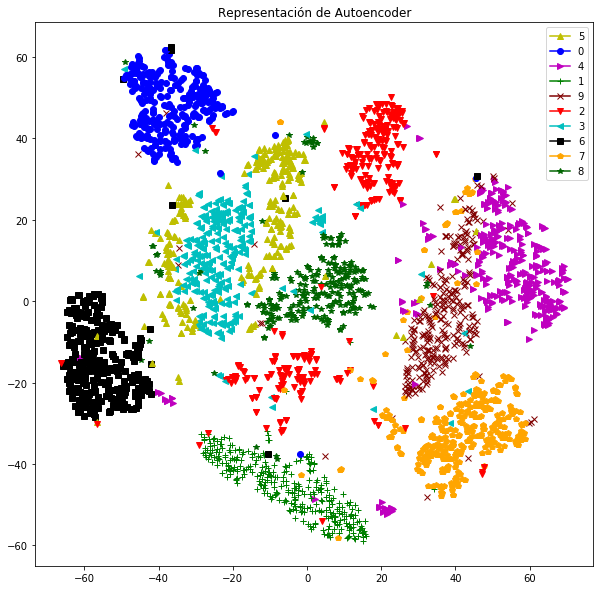


Reducción mediante PCA...


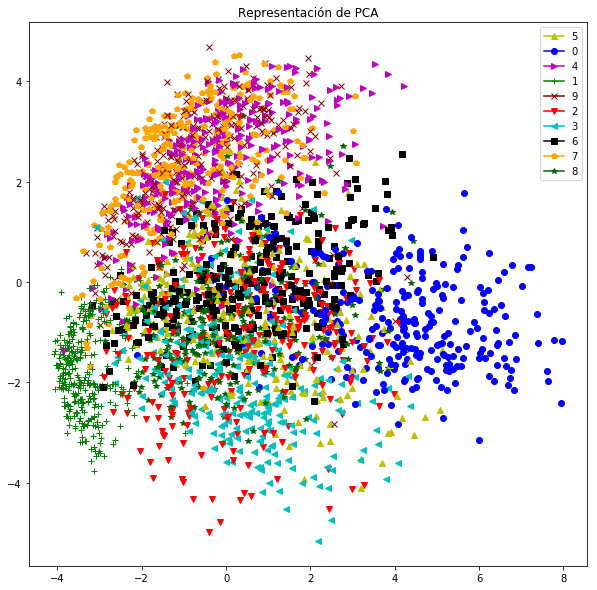

In [90]:
from sklearn.manifold import TSNE
%matplotlib inline
nplot=3000 #modificar!

autoencoder = load_model('./basic_autoencoder_3capasR_768x1000x600x32.h5')
print ("\nReducción mediante Encoder...")  
input_img = autoencoder.input
encoder_layer = autoencoder.layers[-4]
encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-5].output))
encoded_train = encoder.predict(x_train[:nplot])
#encoded_test = encoder.predict(x_test)    
#http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE.fit_transform
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)

plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
vistos=set(np.arange(10))
for idx in np.arange(0,nplot):
    label = y_train[idx]
    if label in vistos:
        #agregar con label solo el primer digito observade de cada tipo 
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6, label = str(label))
        vistos.remove(label)
    else:
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
    
plt.title("Representación de Autoencoder")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(10, 10))
print ("\nReducción mediante PCA...")
pca = PCA(n_components=32)
pca.fit(x_train)
pca_nplot = pca.transform(x_train[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(pca_nplot)
vistos=set(np.arange(10))
for idx in np.arange(0,nplot):
    label = y_train[idx]
    if label in vistos:
        #agregar con label solo el primer digito observade de cada tipo 
        line = plt.plot(pca_nplot[idx][0], pca_nplot[idx][1],
        color=colors[label], marker=markers[label], markersize=6, label = str(label))
        vistos.remove(label)
    else:
        line = plt.plot(pca_nplot[idx][0], pca_nplot[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
    
plt.title("Representación de PCA")
plt.legend(loc="upper right")
plt.show()


En el gráfico anterior se visualizan las representaciones codificadas con el autoencoder y PCA a 32 dimensiones con 3 capas ocultas a través del embedding **t-SNE**. Cada color y figura está asociada a la etiqueta específica de cada ejemplo pudiendo notar que éstos están agrupados en clusters gracias a la codificación de ambos modelos en la que extraen características relevantes de los datos en cada componente y pudiendo así agrupar en base a dichas características.  
Se puede ver que la representación codificada del autoencoder deja los cluster más distantes entre sí y por ende más diferenciados con una clara frontera. Esto resulta bastante distinto cuando se comparan los resultados de PCA en los que los clusters son mucho más difusos.  

**Por ejemplo:** los dígitos 0, 7 y 6 son claramente identificados por el autoencoder mientras que PCA no logra identificar una diferencia clara entre estos dígitos y los demás. Así entonces se demuestra lo antes enunciado; Claramente el modelo deep de autoencoder supera en cuanto a desempeño al modelo PCA. 

> f) Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el Encoder y el Decoder, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.
```python
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()
```


In [91]:

#Reconstruir la estructura espacial  de la imagen 28 x 28 un canal
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val = np.reshape(x_val,(len(x_val),28,28,1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [94]:
from keras.layers.convolutional import *

nput_img = Input(shape=(28, 28, 1))
encodeda = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encodedb = MaxPooling2D((2, 2), border_mode='same')(encodeda)
encodedc = Conv2D(8, (3, 3), activation='relu', padding='same')(encodedb)
encoder_d = MaxPooling2D((2, 2))(encodedc)
decodedc = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder_d)
decodedb = UpSampling2D((2, 2))(decodedc)
decodeda= Conv2D(16, (3, 3), activation='relu', padding='same')(decodedb)

integrado = UpSampling2D((2, 2))(decodeda)
decoded_d = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(integrado)
autoencoder = Model(input_img, decoded_d)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 8)         0         
__________

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`


Aquí se define un autoencoder con capas ocultas convolucionales profundas sobre la representación matricial de las imágenes, pasando por una estructura Conv x Pool x Conv x Pool para codificar el input desde el formato original a 8 canales de 7x7.

In [96]:
history = autoencoder.fit(x_train,x_train,epochs=30,batch_size=32,verbose=0,shuffle=True,validation_data=(x_val, x_val))
autoencoder.save('./basic_autoencoder_convolucional.h5')

In [98]:
autoencoder = load_model('./basic_autoencoder_convolucional.h5')

input_img = autoencoder.input
encoder_layer = autoencoder.layers[-6]
encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-7].output))

encoded_train = encoder.predict(x_train).reshape(len(x_train),7*7*8)
encoded_test = encoder.predict(x_test).reshape(len(x_test),7*7*8)

inicio = time.time()
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print ("Encoder Accuracy ",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")


Encoder Accuracy  0.9607 con 451.8669226169586 segundos


Se evalua el desempeño del autoencoder convolucional mediante el clasificador k-NN para la representación vectorial de los 8 canales de matrices de 7x7 **obteniendo 96% de exactitud**, tal como expusieron los resultados sobre la representación original (28x28). Cabe destacar que este accuracy se obtuvo a costa de un entrenamiento y cómputo que tardó **450 segundos** por lo que se puede afirmar que (en este caso) trabajar con capas convolucionales no proporciona ventajas notorias. 

### 3.2 Denoising
Como se ha discutido en clases, un denoising autoencoder (dAE) es esencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

> a) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $x\in {\rm I\!R}^d$ es una de las imágenes originales, la versión ruidosa $\~{x}$ se obtiene como $\~{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.
```python
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask
```


In [5]:
from numpy.random import binomial

def corromper(x_train,x_val,x_test,ruido):
    noise_level = ruido
    noise_mask_tr = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask_tr
    noise_mask_v = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask_v
    noise_mask_t = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask_t
    
    return noisy_x_train, noisy_x_val, noisy_x_test

En la celda anterior se presenta una primera versión de corrupción de imagen; A cada conjunto (x_train,x_val,x_test) se le realiza un producto componente a componente con un arreglo binario de la misma dimensión del dataset. Este arreglo está dado por una distribución de Bernoulli (una Binomial) tal que cada componente final (o pixel) será activado o desactivado en base a los resultados de la distribución.   
Visto de otra manera, si la probabilidad de éxito (p) es igual a 1, indica que todos los pixeles deberán mantenerse por lo que no existirá ruido, mientras que si este pasa a ser 0, significará que ningún pixel prevalecerá y el ruido será máximo. 

> b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de *p* en el rango (0, 1).
```python
# DEFINE YOUR AUTOENCODER AS BEFORE
autoencoder.fit(noisy_x_train, x_train, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))
```


A continuación se define un denoising autoencoder simple de una única capa oculta con función de activación ReLU para el encoder con dimensionalidad 32. La imagen corrupta estará dada por la función previamente definida tal que el modelo deberá reconstruir la imagen original (sin corrupción).   
Se varía el parámetro p de la probabilidad de Bernoulli a fin de agregar diferentes niveles de ruido y observar qué efectos tiene esto en los resultados finales. 

In [10]:
hist_corruptos = []
ruidos=[0.1,0.2,0.3,0.45,0.75]
for ruido in ruidos:
    print ("Entrenando modelo para ruido p:", ruido)
    noisy_x_train, noisy_x_val, noisy_x_test = corromper(x_train, x_val, x_test, ruido)

    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
       
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(noisy_x_train, x_train, epochs=50, batch_size=32,verbose=0,shuffle=True, validation_data=(noisy_x_val, x_val))    
    autoencoder.save('./corruptos/autoencoder_768x32_p_'+str(ruido)+'.h5')
    hist_corruptos.append(hist)

Entrenando modelo para ruido p: 0.1
Entrenando modelo para ruido p: 0.2
Entrenando modelo para ruido p: 0.3
Entrenando modelo para ruido p: 0.45
Entrenando modelo para ruido p: 0.75


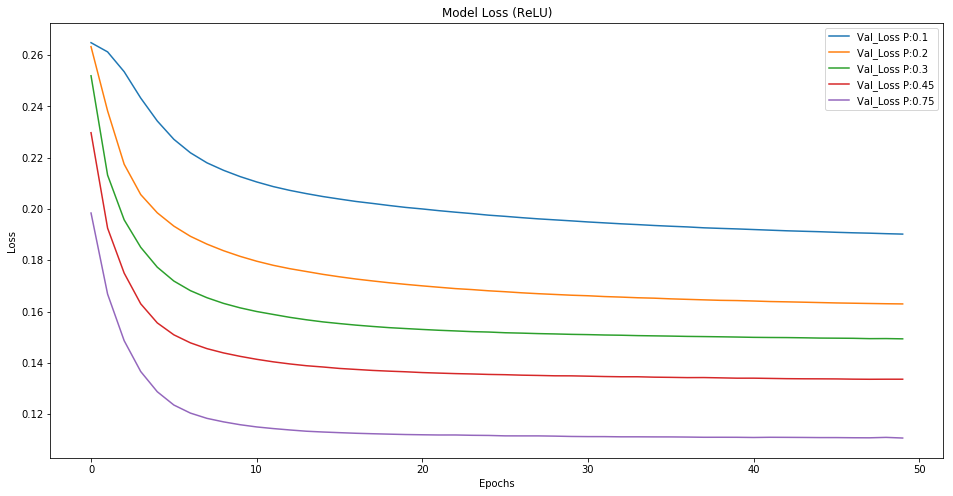

In [11]:
###graficar hists corruptos
import matplotlib.pyplot as plt 
%matplotlib inline

i=0
plt.figure(figsize=(16, 8))
for hist in hist_corruptos: 
    #plt.plot(hist.history['loss'],label="Loss P:"+str(ruidos[i]))
    plt.plot(hist.history['val_loss'],label="Val_Loss P:"+str(ruidos[i]))   
    i+=1
    
plt.title("Model Loss (ReLU)") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

En la celda anterior se presenta el nivel de loss alcanzado para un modelo denoising en base a diferentes niveles de ruido. Así, se observa que para ruidos más leves se logran pérdidas más bajas. Esto es, para **p=0.75, se alcanza loss=0.11** mientras que para **p=0.1, el nivel de loss es 0.20**.  
A modo de comparar el error de reconstrucción de dichos modelos entrenados, se presentan a continuación las imágenes generadas por los autoencoders.

Reconstruyendo modelo para ruido p: 0.1
10000/10000 [==============================] - 1s 58us/step
Error de reconstruccion encoder: 0.19022049844264985


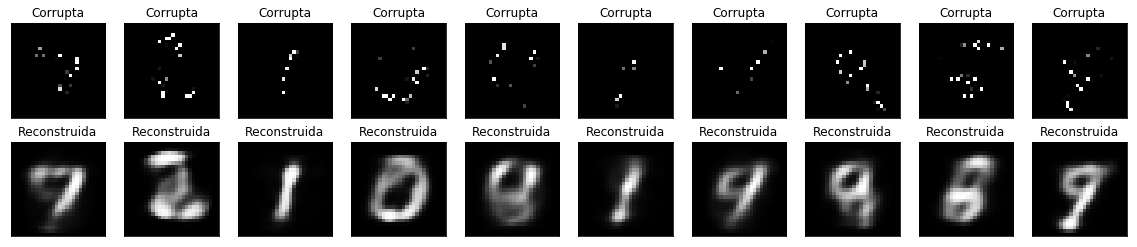

Reconstruyendo modelo para ruido p: 0.2
10000/10000 [==============================] - 1s 58us/step
Error de reconstruccion encoder: 0.1618444983959198


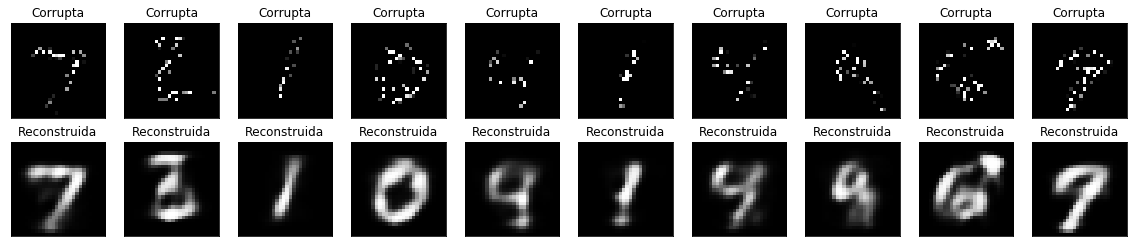

Reconstruyendo modelo para ruido p: 0.3
10000/10000 [==============================] - 1s 62us/step
Error de reconstruccion encoder: 0.14795746564865112


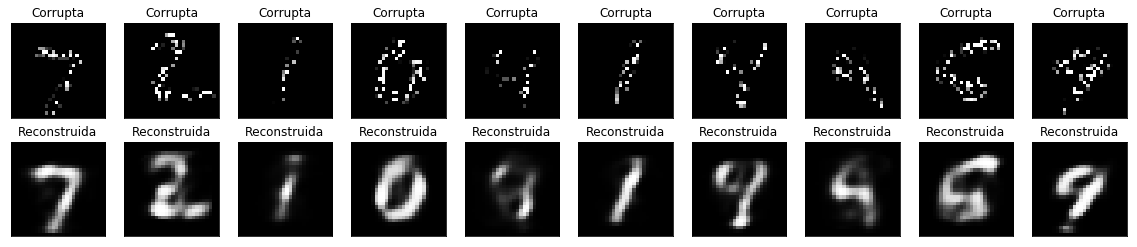

Reconstruyendo modelo para ruido p: 0.45
10000/10000 [==============================] - 1s 63us/step
Error de reconstruccion encoder: 0.1318843430519104


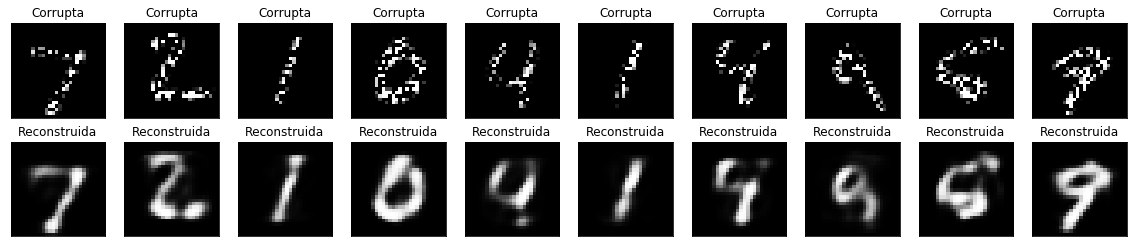

Reconstruyendo modelo para ruido p: 0.75
10000/10000 [==============================] - 1s 65us/step
Error de reconstruccion encoder: 0.10863272032737732


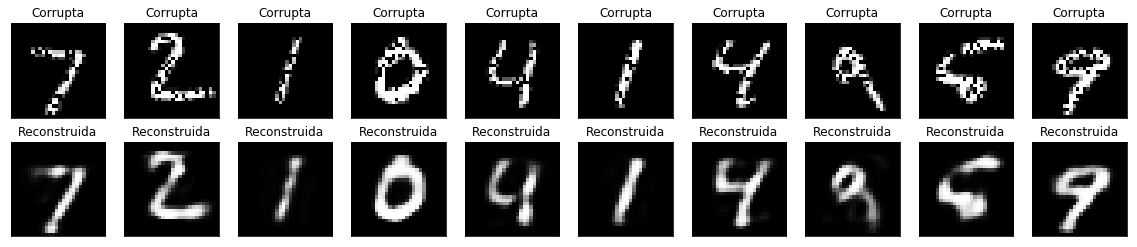

In [12]:
from keras.models import load_model

ruidos=[0.1,0.2,0.3,0.45,0.75]
for ruido in ruidos:
    print ("Reconstruyendo modelo para ruido p:", ruido)
    noisy_x_train, noisy_x_val, noisy_x_test = corromper(x_train, x_val, x_test, ruido)

    autoencoder = load_model('./corruptos/autoencoder_768x32_p_'+str(ruido)+'.h5')
    #Reconstruir desde autoencoder (encoder --> decoder)
    score = autoencoder.evaluate(noisy_x_test,x_test)
    print ("Error de reconstruccion encoder:", score) 
    
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
    decoded_shape = Input(shape=(32,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test) 
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):    
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Corrupta")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruida")    
    plt.show()

Debido a que se observó que a menor nivel de ruido (p más alto) se obtenían mejores reconstrucciones (error de reconstrucción decreciente en base a la disminución de ruido) para el autoencoder, se entrena a continuación un nuevo modelo con probabilidad de retención de un pixel de **0.9**

In [7]:
print ("Entrenando modelo para ruido p: 0.9")
noisy_x_train, noisy_x_val, noisy_x_test = corromper(x_train, x_val, x_test, 0.9)

input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
hist09 = autoencoder.fit(noisy_x_train, x_train, epochs=50, batch_size=32,verbose=0,shuffle=True, validation_data=(noisy_x_val, x_val)) 
autoencoder.save('./corruptos/autoencoder_768x32_p_0.9.h5')

Entrenando modelo para ruido p: 0.9


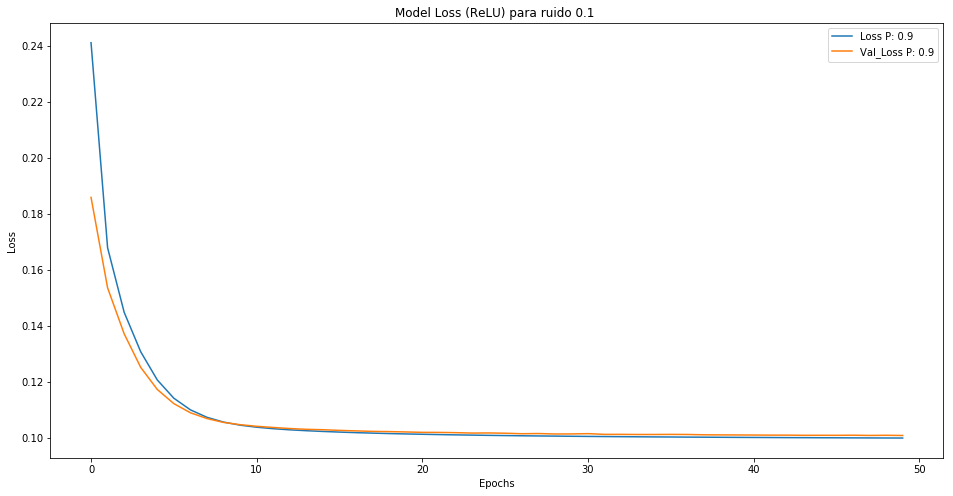

In [16]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.figure(figsize=(16, 8))
plt.plot(hist09.history['loss'],label="Loss P: 0.9")
plt.plot(hist09.history['val_loss'],label="Val_Loss P: 0.9")   

    
plt.title("Model Loss (ReLU) para ruido 0.1 ") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

10000/10000 [==============================] - 0s 50us/step
Error de reconstruccion encoder: 0.0987689493060112
Modelo con 10% de ruido (p:0.9)


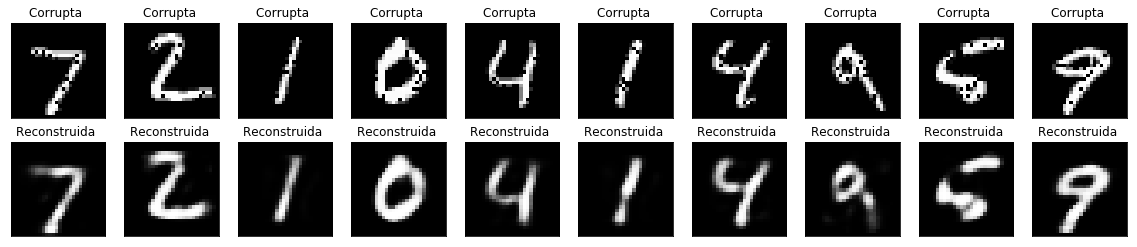

In [17]:
score = autoencoder.evaluate(noisy_x_test,x_test)
print ("Error de reconstruccion encoder:", score) 

input_img = autoencoder.input
encoder_layer = autoencoder.layers[-2]
encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
decoded_shape = Input(shape=(32,))   
decoder_layer = autoencoder.layers[-1] 
decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

encoded_test = encoder.predict(noisy_x_test)
decoded_test = decoder.predict(encoded_test) 
print ("Modelo con 10% de ruido (p:0.9)")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Corrupta ")
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Reconstruida ")    
plt.show()

Así, este último modelo alcanza **loss de 0.1 aproximadamente con error de reconstrucción del 9.87%**.  

En base a la experimentación aquí presente, es posible apreciar que, a pesar de que el modelo se enfrenta a versiones corruptas de imágenes (con zonas ennegrecidas o faltantes), logra discernir de muy buena manera el dígito en cuestión. Así, se aprecia cualitativamente la corrupción de la imagen original para los diferentes valores de **p**, en donde, tal como se explicó, diversos píxeles son asignados a 0 por lo que se esperaría que la poca información presente en la imagen afecte a la extracción de características para la correcta clasificación de la imagen. Esta situación es lo que justamente se observa para niveles de ruido alto. Sin embargo, en la medida que se disminuye el ruido (y por ende se corrompe en menor medida la imagen original), el autoencoder es capaz de reconstruir sin falencias la imagen con el dígito correcto (desde p > 0.45).  
Cabe destacar la gran ventaja que esto presenta puesto que no siempre se tienen a mano ejemplos 100% legibles o en un excelente estado. Por ello, un modelo denoising autoencoder es totalmente adecuado para estas labores.


> c) Utilice estas imágenes intencionalmente corruptas para entrenar un AE con fines de reducción de dimensionalidad. Durante el entrenamiento, proceda exactamente como en (b), pero su objetivo no será hacer *denoising* sino obtener una representación comprimida de alta calidad de las imágenes originales. Al final del entrenamiento, mida el error de reconstrucción como el desempeño en clasificación (vı́a kNN como en la sección anterior) de la representación obtenida. Comente.



In [8]:
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import time

ruidos=[0.1,0.2,0.3,0.45,0.75,0.9]
for ruido in ruidos:
    print ("Para ruido afecto a p:", ruido)
    noisy_x_train, noisy_x_val, noisy_x_test = corromper(x_train, x_val, x_test, ruido)
    autoencoder = load_model('./corruptos/autoencoder_768x32_p_'+str(ruido)+'.h5')
    #Reconstruir desde autoencoder (encoder --> decoder)
    score = autoencoder.evaluate(noisy_x_test,x_test)
    print ("Error de reconstruccion encoder:", score) 
    
    #Reconstruir los encoder desde el autoencoder
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    inicio = time.time()
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))    
    encoded_train = encoder.predict(noisy_x_train)
    encoded_test = encoder.predict(noisy_x_test)

    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ("Encoder Accuracy en base KNN: ",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")


Para ruido afecto a p: 0.1
10000/10000 [==============================] - 1s 57us/step
Error de reconstruccion encoder: 0.1897958010196686
Encoder Accuracy en base KNN:  0.6611 con 67.29077386856079 segundos
Para ruido afecto a p: 0.2
10000/10000 [==============================] - 1s 59us/step
Error de reconstruccion encoder: 0.16180992732048036
Encoder Accuracy en base KNN:  0.8187 con 64.86830139160156 segundos
Para ruido afecto a p: 0.3
10000/10000 [==============================] - 1s 60us/step
Error de reconstruccion encoder: 0.14786213095188142
Encoder Accuracy en base KNN:  0.877 con 62.4911892414093 segundos
Para ruido afecto a p: 0.45
10000/10000 [==============================] - 1s 63us/step
Error de reconstruccion encoder: 0.1320042801618576
Encoder Accuracy en base KNN:  0.9233 con 55.567286014556885 segundos
Para ruido afecto a p: 0.75
10000/10000 [==============================] - 1s 63us/step
Error de reconstruccion encoder: 0.10877301017045975
Encoder Accuracy en base 

En la celda anterior se mide el error de reconstrucción en base a los diferentes valores de **p** utilizados previamente para corromper las imágenes originales. En esta se puede apreciar claramente que, a mayor nivel de ruido (p bajos), mayor es el error de reconstrucción y menor es el nivel de accuracy logrado por el modelo. Así mismo, en la medida que se disminuye el nivel de ruido (p altos), el error de reconstrucción es menor y mayor el accuracy. Sin embargo, resulta bastante llamativo que a mayor ruido, mayor es el tiempo de ejecución. Mientras que para ruidos leves, el tiempo de ejecución es menor. Esto se puede explicar desde el punto de vista de la cantidad de información y/o patrones posibles que se pueden reconocer por parte del modelo dentro de la imagen de entrada. Así, para una entrada más corrupta se deberá incurrir en mayor procesamiento y cálculos que sobre una imagen más limpia si se busca una correcta clasificación del dígito en cuestión. 

En conclusión, niveles demasiado altos de ruido, corrompen notoriamente la imagen y la información presente en ella, mientras que niveles suaves de ruido permiten mejores resultados.

> d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

In [2]:
def corromper_gauss(x_train, x_val, x_test,std):
    noise_mask = std*np.random.standard_normal(size=x_train.shape)
    noisy_x_tr = x_train + noise_mask
    noise_mask = std*np.random.standard_normal(size=x_val.shape)
    noisy_x_v = x_val + noise_mask
    noise_mask = std*np.random.standard_normal(size=x_test.shape)
    noisy_x_t = x_test + noise_mask
    
    return noisy_x_tr, noisy_x_v, noisy_x_t

En la celda anterior se define un nuevo método de corrupción para los conjuntos de datos x_train, x_val y x_test en base a una distribución Normal o ruido Gaussiano. Ésta forma de corromper las imágenes suma un arreglo (modelado como distribución Normal con media 0 y desviación estándar 1) a cada componente del conjunto de datos. Cabe destacar que este tipo de ruido permite su amplificación por una desviación estándar definida a priori.  
Nuevamente, se entrenarán diferentes variantes con el fin de verificar si el autoencoder es capaz de reconstruir la imagen de entrada original (limpia)

In [41]:
hist_corruptos_gauss = []
stdss=[0.05,0.1,0.3,0.45,0.75]
for stds in stdss:
    print ("Entrenando modelo para std:", stds)
    noisy_x_train, noisy_x_val, noisy_x_test = corromper_gauss(x_train, x_val, x_test, stds)

    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
       
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(noisy_x_train, x_train, epochs=50, batch_size=32,verbose=0,shuffle=True, validation_data=(noisy_x_val, x_val))    
    autoencoder.save('./corruptos/autoencoder_768x32_std_'+str(stds)+'.h5')
    hist_corruptos_gauss.append(hist)

Entrenando modelo para std: 0.05
Entrenando modelo para std: 0.1
Entrenando modelo para std: 0.3
Entrenando modelo para std: 0.45
Entrenando modelo para std: 0.75


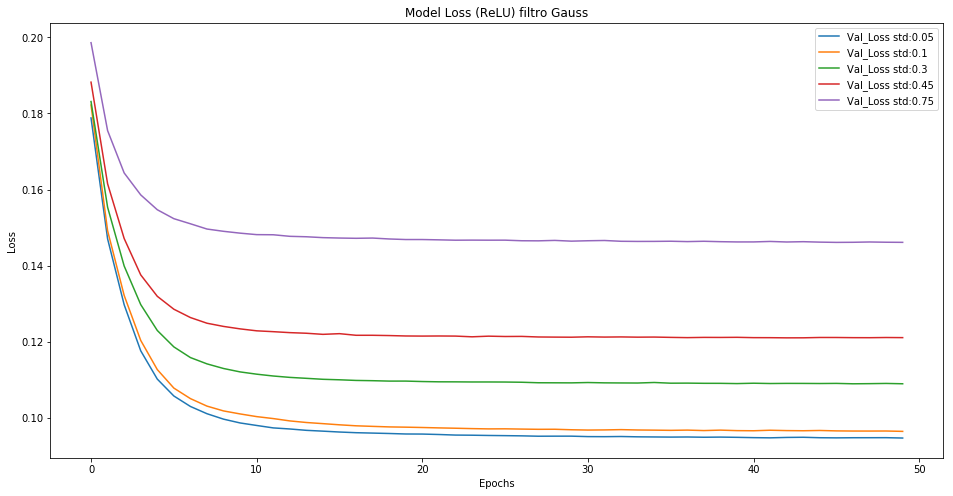

In [45]:
###graficar hists corruptos
import matplotlib.pyplot as plt 
%matplotlib inline

i=0
plt.figure(figsize=(16, 8))
for hist in hist_corruptos_gauss: 
    plt.plot(hist.history['val_loss'],label="Val_Loss std:"+str(stdss[i]))   
    i+=1
    
plt.title("Model Loss (ReLU) filtro Gauss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

Se aprecia que aquellos modelos de mejor desempeño son los que trabajan en base a una desviación estándar baja (0.05 y 0.1) alcanzando valores de loss por debajo de 0.10.  
Observado esto, se presenta a continuación la reconstrucción de los diversos modelos entrenados en los diferentes valores de desviación estándar ya enunciados. 

Considerando modelo para std: 0.05
10000/10000 [==============================] - 1s 53us/step
Error de reconstruccion encoder: 0.09261274490356446
Encoder Accuracy en base KNN:  0.9672 con 36.937411069869995 segundos


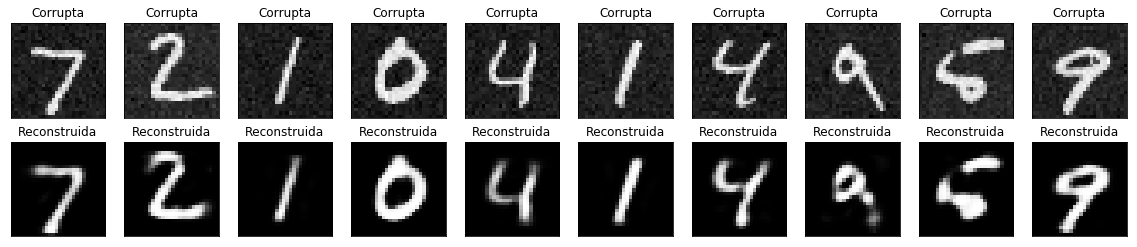

Considerando modelo para std: 0.1
10000/10000 [==============================] - 1s 55us/step
Error de reconstruccion encoder: 0.09444266370534897
Encoder Accuracy en base KNN:  0.9661 con 33.35351538658142 segundos


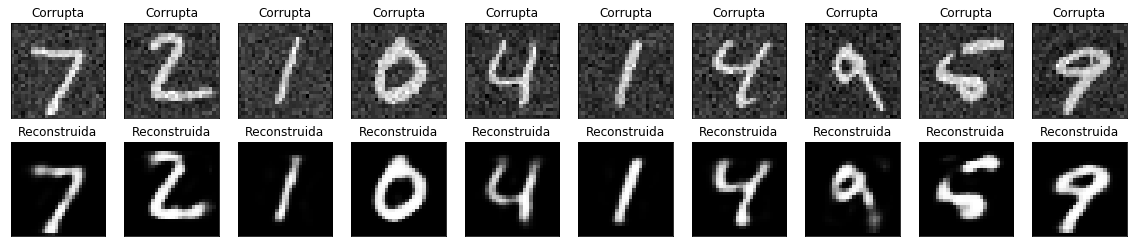

Considerando modelo para std: 0.3
10000/10000 [==============================] - 1s 56us/step
Error de reconstruccion encoder: 0.10656680409908295
Encoder Accuracy en base KNN:  0.9573 con 46.928401708602905 segundos


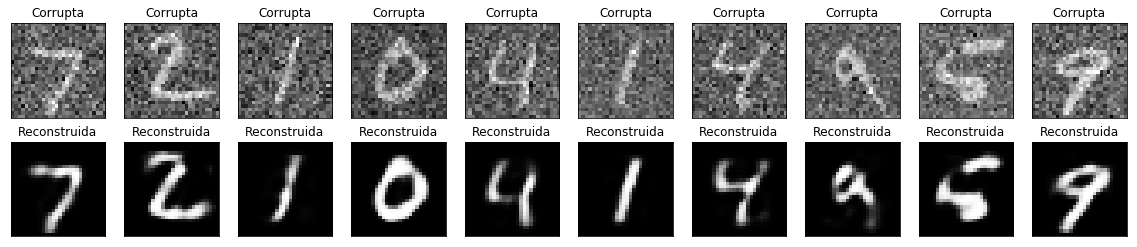

Considerando modelo para std: 0.45
10000/10000 [==============================] - 1s 56us/step
Error de reconstruccion encoder: 0.11889755375385284
Encoder Accuracy en base KNN:  0.9404 con 53.60008120536804 segundos


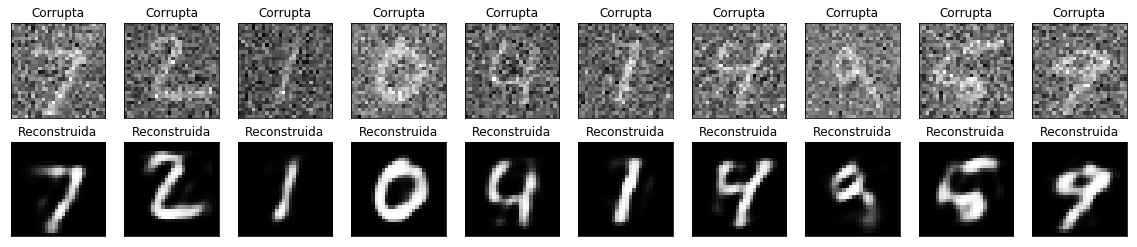

Considerando modelo para std: 0.75
10000/10000 [==============================] - 1s 54us/step
Error de reconstruccion encoder: 0.14379743192195893
Encoder Accuracy en base KNN:  0.8715 con 57.66041445732117 segundos


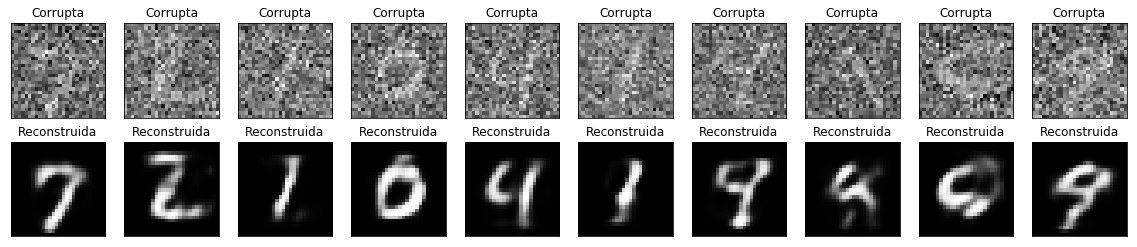

In [14]:
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import time

stdss=[0.05,0.1,0.3,0.45,0.75]
for stds in stdss:
    print ("Considerando modelo para std:", stds)
    noisy_x_train, noisy_x_val, noisy_x_test = corromper_gauss(x_train, x_val, x_test, stds)
    autoencoder = load_model('./corruptos/autoencoder_768x32_std_'+str(stds)+'.h5')
    #Reconstruir desde autoencoder (encoder --> decoder)
    score = autoencoder.evaluate(noisy_x_test,x_test)
    print ("Error de reconstruccion encoder:", score)     
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    inicio = time.time()
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
    decoded_shape = Input(shape=(32,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))       
    encoded_train = encoder.predict(noisy_x_train)
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)   
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ("Encoder Accuracy en base KNN: ",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")

    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):    
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Corrupta")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruida")    
    plt.show()
    


Se puede notar que, a diferencia del método anterior, la corrupción no deja pixeles muertos (o en 0) sino que se suavizan las zonas de la imagen por lo que se podría enunciar que este tipo de ruido es más cercano a lo que ocurre en la mayoria de los problemas/aplicaciones reales (píxeles con intensidades similares en los distintos puntos de la imagen).   
Igualmente, se aprecia que aquellos modelos entrenados bajo desviación estándar bajos son los que obtienen mejor desempeño, lo que se corresponde con el nivel de loss acusado en las celdas previas. Así entonces aquellos modelos con std=0.05 y 0.1 obtienen error de reconstrucción/accuracy de 0.0926/0.9672 y 0.0944/0.9661 respectivamente, mientras que para std mayores, tanto el error de reconstrucción como accuracy empeoran.  
Se observa cualitativamente que con una menor desviación estándar entonces, la imagen reconstruida se ve mucho más completa y clara en comparación con las imágenes de alta std las cuales se tornan más difusas. esto se debe a que, a medida que el grado de dispersión (std) aumenta, la claridad o enfoque de lo que se requiere analizar (o reconstruir en este caso particular) se pierde haciendo más compleja la tarea propuesta.



## **Experimentación Extra**: 


Con el propósito de proponer un nuevo método de corrupción de imágenes y estudiar el efecto (así como desempeño) que esto tiene sobre las predicciones del modelo de Autoencoder simple, se aplicará a continuación un filtro por ventanas tal que a la imagen original se le aplique una gaussiana por secciones. Vale decir, a la imagen $I$ se le dividirá en $R$ regiones cuadradas y a cada una de estas regiones se le aplicará una máscara gaussiana. La gauusiana se define en base a la probabilidad de ocurrencia de una determinada muestra en una cierta subregión.  
Así entonces, inicialmente se muestrean de manera aleatoria $R=16$ muestras tal que permitan el filtro hacia una "matriz 4x4" donde cada una de sus entradas se compondrá de 49 subregiones ("matriz 7x7") que representan la frecuencia de ocurrencia, para los puntos muestreados, dentra de tal subregión. 


Para ser más evidente, el método propuesto se asimila a lo presentado a continuación, pero con 16 regiones (4x4), cada una con un filtro gaussiano.

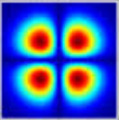

In [41]:
from IPython.display import Image
Image("ventanas.jpeg", width=300, height=300)

A continuación se presentan las funciones auxiliares utilizadas en la experimentación:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import scipy

def isPSD(A, tol=1e-8):
    E,V = scipy.linalg.eigh(A)
    return np.all(E > -tol)

covs=[[[1.2,-2.0],[-2.0,1.2]], [[2.3,-0.23],[-0.23,2.3]], [[1,0],[0,1]],[[1.2,-0.3],[-0.3,1.2]],[[0.12,1.3],[1.3,0.12]], 
      [[1.17,0.29],[0.29,1.17]], [[0.13,1.2],[1.2,0.13]], [[0.22,2.7],[2.7,0.22]], [[0.15,2.5],[2.5,0.15]], 
      [[1,-2.6],[-2.6,1]] , [[0.23,1.3],[1.3,0.23]]]

def filtroVision_gauss(n_bloques, covs):
    muestras_gauss=[]
    for n_bloq in range(n_bloques*n_bloques):
        mean=[np.random.randint(5),np.random.randint(5)]
        random=np.random.randint(3)
        cov=covs[np.random.randint(len(covs))]
        while(not isPSD(cov, tol=1e-8)):
            cov=covs[np.random.randint(len(covs))]
        print (cov)
        muestras_gauss_temp=[]
        for i in range(4000):
            muestras_gauss_temp.append(multivariate_normal(mean,cov).rvs().tolist())
        muestras_gauss.append(muestras_gauss_temp)
    return muestras_gauss
        
            

In [12]:
def rangos(minx,maxx,cuadros):  #obtiene rangos numericos para post conteo de muestras en region
    rangos=[]
    rangox=(maxx-minx)/(cuadros-1)
    for i in range(cuadros):
        rangos.append(minx+i*rangox)
    return rangos
    


def maper2pic(muestra,dim1,dim2): #retorna arreglos de dim1*dim2 con conteos por region
    minx=min(muestra[:,0])
    maxx=max(muestra[:,0])
    miny=min(muestra[:,1])
    maxy=max(muestra[:,1])    
    ys=rangos(miny,maxy,dim2+1)
    xs=rangos(minx,maxx,dim1+1)
    #conteos por region
    totales=[]
    for y in range(len(ys)-1):
        for x in range(len(xs)-1):
            total=0
            #print ("la reguon es X en", xs[x], "y", xs[x+1])
            #print ("y con Y en", ys[y], "y", ys[y+1])
            for ele in muestra:
                #sum(i >= xs[x] and i < xs[x+1] for i in muestra[:,0])
                if ele[0]>= xs[x] and ele[0]<xs[x+1] and ele[1]>= ys[y] and ele[1]<ys[y+1]:
                    total+=1
            #print ("HAY", total, "en la region")
            totales.append(total)
    
    return totales

def normalizar(arreglo): #transforma conteos a probabilidades
    arreglo2=[]
    for arr in arreglo:
        arreglo2.append(arr/np.sum(arreglo))
    return arreglo2

def transTo784(retornotemp): ##recibe vector incorrecto (reordenar como 16 vector de 49)    
    return retornotemp

def gauss_tamShape(shape, muestras16):   #este hará las 55000 muestras  ._.
    retorno=[]   ##vector de 784 componentes
    for i in range(shape[0]):
        retornotemp=[]
        for muestra in muestras16:
            retornotemp.append(normalizar(maper2pic(np.asarray(muestra),7,7)))#retornotemp son 6 gauss en vectores de 49 (7x7)
        print ("retorno temp tiene ",len(retornotemp),"vectores")
        retornotemp=transTo784(retornotemp)
        retorno.append(retornotemp)   
    return retorno

def obtenermuestras(muestras16):
    retornotemp=[]
    for muestra in muestras16:
        a=normalizar(maper2pic(np.asarray(muestra),7,7))
        retornotemp.append(a)#retornotemp son 6 gauss en vectores de 49 (7x7)
    return retornotemp

def transformar784(vector16_49):
    vector784=[]
    multiplos7=np.arange(0,49,7)
    j=0
    for i in range(len(vector16_49)):
        if i%4==0: #entra en vectores 0,4,8,12
            for k in multiplos7:
                print (i,j,k)
                vector784.extend(vector16_49[j][k:k+7])
                vector784.extend(vector16_49[j+1][k:k+7])
                vector784.extend(vector16_49[j+2][k:k+7])
                vector784.extend(vector16_49[j+3][k:k+7])
            j+=4        
    return vector784
    

In [7]:
gaussianas=filtroVision_gauss(4, covs)

[[2.3, -0.23], [-0.23, 2.3]]
[[1.2, -0.3], [-0.3, 1.2]]
[[2.3, -0.23], [-0.23, 2.3]]
[[1, 0], [0, 1]]
[[1.17, 0.29], [0.29, 1.17]]
[[1.17, 0.29], [0.29, 1.17]]
[[2.3, -0.23], [-0.23, 2.3]]
[[1.17, 0.29], [0.29, 1.17]]
[[1, 0], [0, 1]]
[[2.3, -0.23], [-0.23, 2.3]]
[[2.3, -0.23], [-0.23, 2.3]]
[[1.2, -0.3], [-0.3, 1.2]]
[[1.2, -0.3], [-0.3, 1.2]]
[[2.3, -0.23], [-0.23, 2.3]]
[[1.17, 0.29], [0.29, 1.17]]
[[1.2, -0.3], [-0.3, 1.2]]


In [10]:
array=transformar784(obtenermuestras(gaussianas))

En la celda siguiente, se define el método de corrupción recién expuesto "filtro Normal por ventanas" para los conjuntos de datos x_train, x_val y x_test. así, el método realiza como operación el producto/multiplicación de los valores de las imágenes originales por los ruidos componente a componente. Cabe destacar que, al tratarse de multiples zonas dentro de una imagenes, las probabilidades de ocurrencia serán bastante bajas por lo que se espera que los ruidos sean inherentemente fuertes (entradas cercanas a 0). Para evitar tal fenómeno se definie dentro del método un parámetro 'k' que reduce el efecto de los ruidos.  

Nuevamente, se entrenarán diferentes variantes con el fin de verificar si el autoencoder es capaz de reconstruir la imagen de entrada original (limpia)

In [15]:
def corromper_normal(x_train, x_val, x_test, array,k):
    noisy_x_tr = x_train *  k* np.asarray(np.tile(array,(x_train.shape[0],1)))
    noisy_x_v = x_val * k* np.asarray(np.tile(array,(x_val.shape[0],1)))
    noisy_x_t = x_test * k*np.asarray(np.tile(array,(x_test.shape[0],1)))
    
    return noisy_x_tr, noisy_x_v, noisy_x_t


In [29]:
hist_corruptos_ventanas = []
ks=[1,100,200,500]
for k in ks:
    print ("Entrenando modelo para k:", k)
    noisy_x_train, noisy_x_val, noisy_x_test = corromper_normal(x_train, x_val, x_test, array,k)
    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
       
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(noisy_x_train, x_train, epochs=50, batch_size=32,verbose=0,shuffle=True, validation_data=(noisy_x_val, x_val))    
    autoencoder.save('./corruptos/autoencoder_768x32_normail_K_'+str(k)+'.h5')
    hist_corruptos_ventanas.append(hist)

Entrenando modelo para k: 1
Entrenando modelo para k: 100
Entrenando modelo para k: 200
Entrenando modelo para k: 500


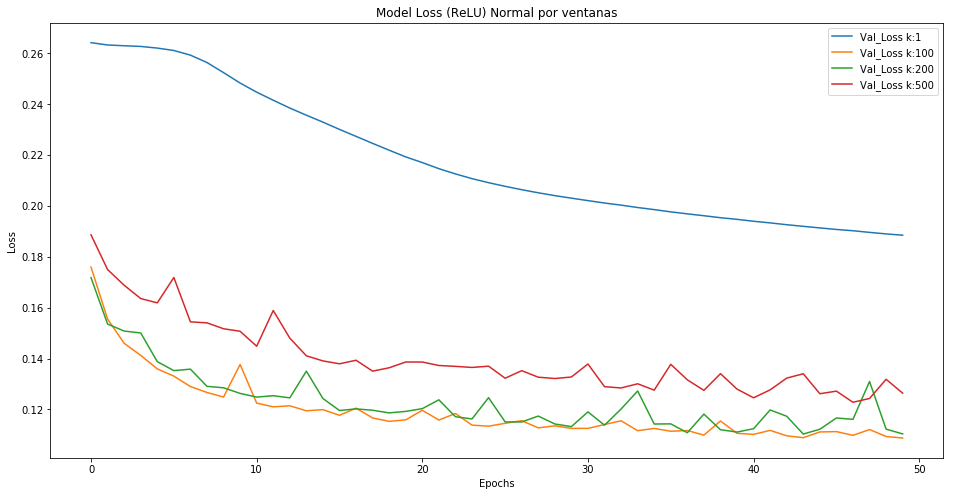

In [31]:
###graficar hists corruptos
import matplotlib.pyplot as plt 
%matplotlib inline

i=0
plt.figure(figsize=(16, 8))
for hist in hist_corruptos_ventanas: 
    plt.plot(hist.history['val_loss'],label="Val_Loss k:"+str(ks[i]))   
    i+=1
    
plt.title("Model Loss (ReLU) Normal por ventanas") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

Se aprecia entonces el desempeño obtenido por lo modelos entrenados, de él se desprende que aquel modelo amplificado por un factor de $100$ es el de mejores resultados. Es decir, el de valores de loss más bajos. Así mismo, se observa que el aprendizaje, en términos de número de epochs transcurridos para alcanzar niveles aceptables de pérdida, es bastante veloz (menos de 3 epochs). Esto se puede explicar debido a la cantidad de información que maneja el modelo, la cual se redujo considerablemente respecto a la experimentación previa.   

Habiendo aclarado esto, se presenta a continuación la reconstrucción de los diversos modelos entrenados en los diferentes valores de $k$.

Considerando modelo para k: 1
10000/10000 [==============================] - 1s 65us/step
Error de reconstruccion encoder: 0.18668620336055755
Encoder Accuracy en base KNN:  0.7803 con 9.715763330459595 segundos


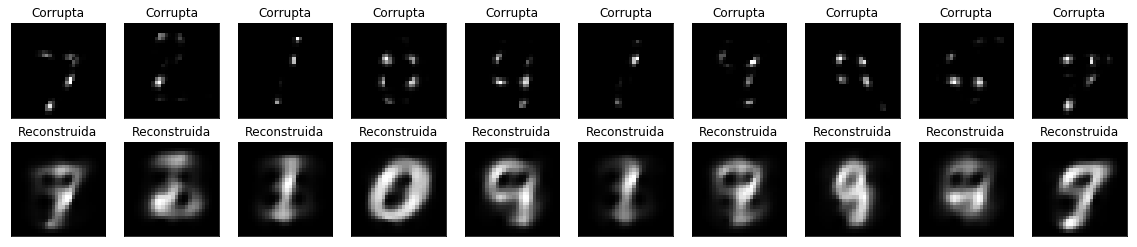

Considerando modelo para k: 100
10000/10000 [==============================] - 1s 65us/step
Error de reconstruccion encoder: 0.10676521241664887
Encoder Accuracy en base KNN:  0.9432 con 34.60855984687805 segundos


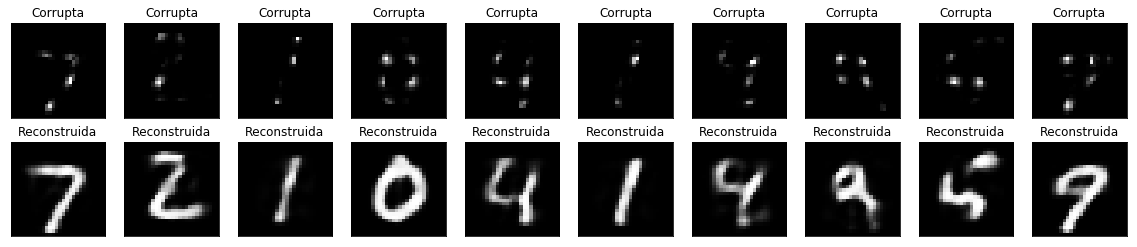

Considerando modelo para k: 200
10000/10000 [==============================] - 1s 62us/step
Error de reconstruccion encoder: 0.10859034323692322
Encoder Accuracy en base KNN:  0.9536 con 35.988746881484985 segundos


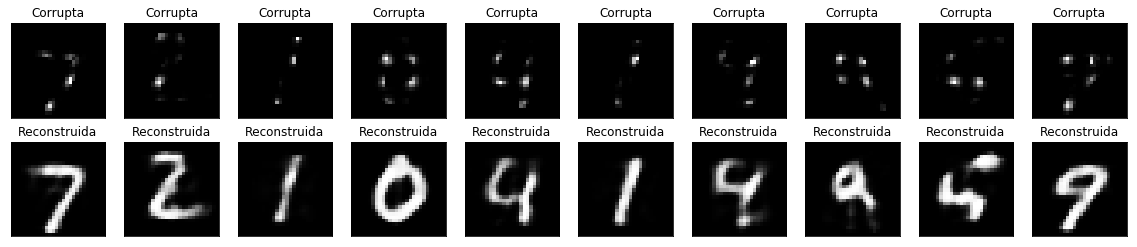

Considerando modelo para k: 500
10000/10000 [==============================] - 1s 66us/step
Error de reconstruccion encoder: 0.12629127578735352
Encoder Accuracy en base KNN:  0.9469 con 31.969825983047485 segundos


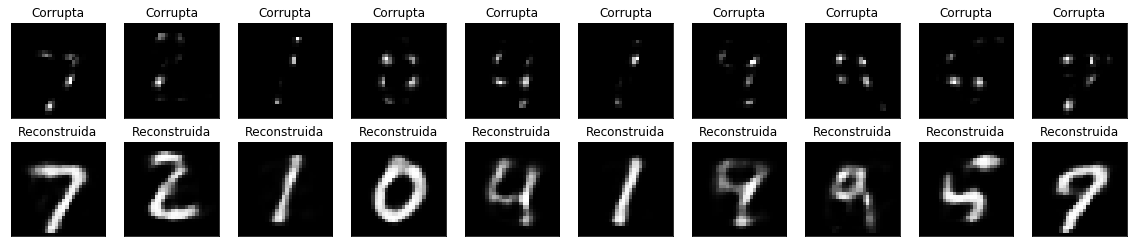

In [32]:
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import time

for k in ks:
    print ("Considerando modelo para k:", k)
    noisy_x_train, noisy_x_val, noisy_x_test = corromper_normal(x_train, x_val, x_test, array, k)
    autoencoder = load_model('./corruptos/autoencoder_768x32_normail_K_'+str(k)+'.h5')
    #Reconstruir desde autoencoder (encoder --> decoder)
    score = autoencoder.evaluate(noisy_x_test,x_test)
    print ("Error de reconstruccion encoder:", score)     
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    inicio = time.time()
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
    decoded_shape = Input(shape=(32,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))       
    encoded_train = encoder.predict(noisy_x_train)
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)   
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print ("Encoder Accuracy en base KNN: ",clf.score(encoded_test,y_test),"con", (time.time() - inicio),"segundos")
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):    
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Corrupta")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruida")    
    plt.show()
    


Entre las observaciones destacan: 

- El tiempo de cómputo requerido por el sistema crece de manera proporcional al factor de amplificación 'k'. Este debido a que en la medida que 'k' aumente, se espera que mayor información esté disponible para la tarea. Cabe destacar que para k=500 no se observaron diferencias significativas en el tiempo requerido ni en el error de reconstrucción respecto al modelo con k=200. Esto debido a que, dadas las dimensiones de las subregiones, amplificar o mantener 'k' en 100 no proporciona mayor información dentro de ese subespacio.  
- Con el objetivo de reducir la información presente en la entrada y de asimilar en cierto modo un enfoque "atencional" puesto que sólo se observan determinados patrones de la imagen (que representarán curvatura, extensión, entre otras características de escritura), es fácil notar que el modelo logra reconstruir de muy buena manera los dígitos presentes en las entradas (loss < 0.19 para el modelo más básico y loss < 0.13 para sus variantes). 
- Considerando el accuracy del modelo aplicando Normales por ventana, se puede apreciar que logra desempeños tan competentes como los antes testeados (0.95 - 0.96). 

Así entonces, se concluye nuevamente que los modelos de autoencoder se comportan bastante bien frente a data corrupta, ilegible o con cualquier otro tipo de ruido que impida manejar entradas 100% confiables. 
  
  
** NOTA: **  
Queda propuesto variar el modelo de corrupción Normal por ventanas a fin de que éstas trabajen sobre menos regiones y abarquen zonas claves de las imágenes de entrada así como la generación de muestras aleatorias para cada ejemplo del conjunto de entrenamiento/validación a fin de obtener diferentes máscaras Gaussianas. 

